In [1]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model words
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [92]:
import numpy as np
import gensim
import os
import re

# changed import from smart_open to file_or_filename
from gensim.utils import file_or_filename, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd
import matplotlib.pyplot as plt

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [6]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [7]:
titles = [t[:-4] for t in os.listdir(path)]

In [8]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [9]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [10]:
df = pd.DataFrame(index=titles)

In [11]:
df.head()

""
Austen_Emma0000
Austen_Emma0001
Austen_Emma0002
Austen_Emma0003
Austen_Emma0004


In [12]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [13]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [14]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [15]:
df.head()

,author,book,section
Austen_Emma0000,1,Emma,0
Austen_Emma0001,1,Emma,1
Austen_Emma0002,1,Emma,2
Austen_Emma0003,1,Emma,3
Austen_Emma0004,1,Emma,4


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [43]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            # tokens = tokenize(str(text))
            yield tokenize(str(text))

### Gensim LDA Topic Modeling

* Possible stretch goal: Named Entity Recognition preprocessing

https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

Word - Topic Matrix calculation: chinese restaurant process

Two popular sampling processes are variational Bayes and Gibbs Sampling

alpha parameter: number of word topics

beta parameter: number of document topics

In [44]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [45]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England"))

[(2753, 1), (3986, 2), (6601, 1), (6818, 1)]

In [46]:
print(id2word)

Dictionary(22095 unique tokens: ['able', 'accepted', 'acquaintance', 'activity', 'actual']...)


In [48]:
len(id2word), len(id2word.keys())

(22095, 22095)

In [49]:
import sys

sys.getsizeof(id2word)

56

In [50]:
dir(id2word)[33:]

['_abc_impl',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_documents',
 'cfs',
 'compactify',
 'dfs',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'from_corpus',
 'from_documents',
 'get',
 'id2token',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'load',
 'load_from_text',
 'merge_with',
 'num_docs',
 'num_nnz',
 'num_pos',
 'patch_with_special_tokens',
 'save',
 'save_as_text',
 'token2id',
 'values']

In [51]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)

In [52]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [55]:
corpus[0][::20]

[(0, 1),
 (20, 1),
 (40, 1),
 (60, 1),
 (80, 1),
 (100, 1),
 (120, 1),
 (140, 1),
 (160, 2),
 (180, 1),
 (200, 1),
 (220, 1),
 (240, 1),
 (260, 3),
 (280, 1)]

In [56]:
# random_state won't always return the same results
# passes is the number of iterations of the sampling algorithm
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [68]:
dir(lda)[28:]

['_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'batch',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_alpha',
 'optimize_eta',
 'passes',
 'per_word_topics',
 'print_topic',
 'print_topics',
 'random_state',
 'save',
 'show_topic',
 'show_topics',
 'state',
 'sync_state',
 'top_topics',
 'update',
 'update_alpha',
 'update_eta',
 'update_every',
 'workers']

In [69]:
lda.print_topics()

[(0,
  '0.009*"tea" + 0.008*"england" + 0.008*"light" + 0.007*"hearth" + 0.007*"home" + 0.006*"frances" + 0.006*"old" + 0.004*"grandmother" + 0.004*"took" + 0.004*"like"'),
 (1,
  '0.046*"jane" + 0.025*"sir" + 0.018*"shall" + 0.016*"miss" + 0.012*"know" + 0.010*"think" + 0.009*"love" + 0.009*"dear" + 0.009*"come" + 0.008*"oh"'),
 (2,
  '0.009*"weston" + 0.008*"thing" + 0.008*"emma" + 0.006*"day" + 0.006*"soon" + 0.006*"frank" + 0.005*"churchill" + 0.005*"coming" + 0.005*"think" + 0.005*"man"'),
 (3,
  '0.024*"marianne" + 0.024*"elinor" + 0.010*"willoughby" + 0.010*"sister" + 0.010*"jennings" + 0.008*"dashwood" + 0.007*"miss" + 0.006*"mother" + 0.006*"know" + 0.006*"john"'),
 (4,
  '0.013*"elizabeth" + 0.009*"darcy" + 0.007*"bennet" + 0.006*"miss" + 0.006*"jane" + 0.006*"bingley" + 0.006*"know" + 0.006*"sister" + 0.005*"think" + 0.005*"soon"'),
 (5,
  '0.013*"pounds" + 0.013*"thousand" + 0.011*"father" + 0.009*"dashwood" + 0.008*"thing" + 0.007*"years" + 0.007*"mother" + 0.006*"emma" + 

In [57]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [62]:
words[::5][::2]

[['tea',
  'england',
  'light',
  'hearth',
  'home',
  'frances',
  'old',
  'grandmother',
  'took',
  'like'],
 ['like',
  'thought',
  'night',
  'day',
  'know',
  'long',
  'saw',
  'rochester',
  'house',
  'hand']]

In [72]:
topics = [' '.join(t[0:5]) for t in words]

In [73]:
print(topics[0])

tea england light hearth home


## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

This is helpful for inspecting if you have too many/too few topics. Also, you can inspect each topic and see what each topic is about.

In [74]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [75]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.063472 -0.005239       1        1  32.068672
4      0.083631  0.035550       2        1  16.238123
7      0.085486 -0.032205       3        1  15.331347
12    -0.095249 -0.013953       4        1  10.557548
3      0.106033  0.079755       5        1   6.615864
9     -0.124448  0.016652       6        1   6.529393
8      0.109416  0.078417       7        1   4.536302
13    -0.121726  0.056321       8        1   1.842934
1      0.077080 -0.076164       9        1   1.761439
2      0.064941 -0.053893      10        1   1.583878
11    -0.122537  0.063356      11        1   1.448046
5      0.081039 -0.065017      12        1   0.480557
14     0.055533  0.078886      13        1   0.436493
6     -0.033680 -0.125019      14        1   0.411561
0     -0.102049 -0.037446      15        1   0.157841, topic_info=     Category         Freq        Term        Total  loglift  logprob
139   Default   927.000000        jane   927.000000  30.0000  30.0000
81    Default   858.000000        emma   858.000000  29.0000  29.0000
4182  Default   685.000000      elinor   685.000000  28.0000  28.0000
170   Default  1538.000000        miss  1538.000000  27.0000  27.0000
4185  Default   567.000000    marianne   567.000000  26.0000  26.0000
372   Default  1439.000000        know  1439.000000  25.0000  25.0000
376   Default  1340.000000        like  1340.000000  24.0000  24.0000
421   Default   596.000000         sir   596.000000  23.0000  23.0000
820   Default   886.000000        room   886.000000  22.0000  22.0000
418   Default   924.000000       shall   924.000000  21.0000  21.0000
258   Default   785.000000       thing   785.000000  20.0000  20.0000
278   Default   428.000000      weston   428.000000  19.0000  19.0000
260   Default  1316.000000       think  1316.000000  18.0000  18.0000
261   Default  1147.000000     thought  1147.000000  17.0000  17.0000
1202  Default   632.000000   elizabeth   632.000000  16.0000  16.0000
93    Default   508.000000      father   508.000000  15.0000  15.0000
125   Default   493.000000        home   493.000000  14.0000  14.0000
173   Default   666.000000      mother   666.000000  13.0000  13.0000
232   Default   585.000000      sister   585.000000  12.0000  12.0000
183   Default   479.000000         old   479.000000  11.0000  11.0000
428   Default   615.000000        sure   615.000000  10.0000  10.0000
322   Default   587.000000        dear   587.000000   9.0000   9.0000
918   Default   524.000000     harriet   524.000000   8.0000   8.0000
241   Default   925.000000        soon   925.000000   7.0000   7.0000
109   Default   827.000000       great   827.000000   6.0000   6.0000
157   Default   909.000000         man   909.000000   5.0000   5.0000
312   Default   835.000000        come   835.000000   4.0000   4.0000
3745  Default   402.000000      madame   402.000000   3.0000   3.0000
59    Default  1064.000000         day  1064.000000   2.0000   2.0000
934   Default   308.000000       light   308.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
4015  Topic15     1.156096       plate    29.582333   3.2092  -5.9700
2303  Topic15     1.685596    campbell    50.003601   3.0614  -5.5929
4892  Topic15     2.875551     frances   116.806770   2.7471  -5.0588
1262  Topic15     1.713303    arranged    64.807129   2.8183  -5.5766
2826  Topic15     1.156197       swept    34.747395   3.0484  -5.9699
715   Topic15     1.718255       truly    72.737862   2.7058  -5.5737
1835  Topic15     1.154819     possess    37.189663   2.9793  -5.9711
934   Topic15     3.411596       light   308.158844   1.9479  -4.8879
2681  Topic15     1.161043      roused    45.481804   2.7833  -5.9657
125   Topic15     3.155374        home   493.960175   1.3980  -4.9659
2235  Topic15     0.842488  perfection    22.914412   3.1482  -6.2864
183   Topic15     2.595057   

### Overall Model / Documents

In [80]:
corpus[0][::20]

[(0, 1),
 (20, 1),
 (40, 1),
 (60, 1),
 (80, 1),
 (100, 1),
 (120, 1),
 (140, 1),
 (160, 2),
 (180, 1),
 (200, 1),
 (220, 1),
 (240, 1),
 (260, 3),
 (280, 1)]

In [81]:
lda[corpus[0]]

[(4, 0.112798184), (7, 0.8807709)]

In [76]:
distro = [lda[d] for d in corpus]

In [77]:
distro[0]

[(4, 0.11332558), (7, 0.880894)]

In [82]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [85]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [86]:
df.head()

,tea england light hearth home,jane sir shall miss know,weston thing emma day soon,marianne elinor willoughby sister jennings,elizabeth darcy bennet miss jane,pounds thousand father dashwood thing,room weston thing like dancing,emma miss harriet weston knightley,elinor edward lucy mother think,miss madame like dr paul,like thought night day know,pelet madame monsieur reuter vous,like madame bretton graham room,monsieur mdlle english henri reuter,marianne sister margaret elinor shall,author
Austen_Emma0000,0.0,0.000000,0.0,0.0,0.113326,0.0,0.0,0.880894,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0001,0.0,0.107975,0.0,0.0,0.000000,0.0,0.0,0.889468,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0002,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.997421,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0003,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.682868,0.313349,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0004,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.997683,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Austen


In [87]:
df.groupby('author').mean()

,tea england light hearth home,jane sir shall miss know,weston thing emma day soon,marianne elinor willoughby sister jennings,elizabeth darcy bennet miss jane,pounds thousand father dashwood thing,room weston thing like dancing,emma miss harriet weston knightley,elinor edward lucy mother think,miss madame like dr paul,like thought night day know,pelet madame monsieur reuter vous,like madame bretton graham room,monsieur mdlle english henri reuter,marianne sister margaret elinor shall
author,,,,,,,,,,,,,,,
Austen,0.000115,0.018993,0.030888,0.137463,0.351511,0.009165,0.005639,0.322107,0.091936,0.000407,0.016081,0.001570,0.002066,0.000905,0.008277
CBronte,0.002262,0.018015,0.002562,0.000738,0.017136,0.001133,0.002289,0.005264,0.004562,0.116071,0.586019,0.024087,0.185662,0.030873,0.000533


## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [1]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [98]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

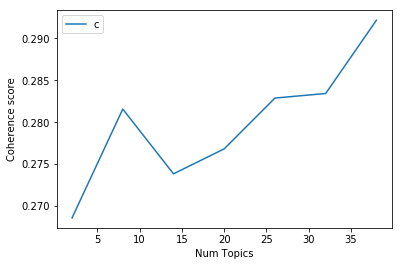

In [99]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [100]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =a", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2686
Num Topics = 8  has Coherence Value of 0.2816
Num Topics = 14  has Coherence Value of 0.2738
Num Topics = 20  has Coherence Value of 0.2768
Num Topics = 26  has Coherence Value of 0.2829
Num Topics = 32  has Coherence Value of 0.2834
Num Topics = 38  has Coherence Value of 0.2921


## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)